In [1]:
import numpy as np
import scipy
import scipy.stats
import nibabel as nib
import nilearn
from nilearn import surface
from nilearn import plotting
import pandas as pd
import glob
import os
import pdb
import pickle
from tqdm import tqdm, trange
from multiprocessing import Process, Manager
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from scipy.stats import pearsonr, zscore

from matplotlib import pyplot
from matplotlib.pyplot import *
from IPython.display import set_matplotlib_formats

import warnings
set_matplotlib_formats('png', 'pdf')


import open3d
from scipy.sparse import csc_matrix, isspmatrix
import seaborn as sns

/home/lamk5/miniconda3/envs/tf2-4/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


### Spatial regularization

Given questionnaire data $M \in \mathbb{R}_+^{n \times m}$ ($n$ subjects and $m$ items), we seek a linear factorization that approximate $M \approx UQ^T$, where $U$ can be considered as an embedding of subjects.

Denote $F \in \mathbb{R}^{n \times N}$ to be the structural images, where $N$ is the number of vertices, we use $U$ to approximate $F$ through
$$
\min_x D(F, UX^T) + \lambda \mathcal{R}(X)
$$


where the regularizer $\mathcal{R}(X)$ is defined as

\begin{split}
\mathcal{R}(X) &= \frac{1}{2} \sum^N_{a, b = 1} W_{ab} \Vert X_a - X_b \Vert^2_2 = \sum^N_{a=1} D_{aa} \langle X_a, X_a \rangle - \sum^N_{a,b = 1, a\neq b} W_{ab} \langle X_a, X_b \rangle \\
&= \text{Tr}\left( X^T (D - W) X \right) \\
&= \text{Tr}(X^T L X)
\end{split}

By simplification, we have

\begin{split}
&\underset{X}{\arg\min} \ \Vert F - UX^T \Vert_F^2 + \lambda \text{Tr}(X^TLX) \\
=& \underset{X}{\arg\min} \ \text{Tr}( (F - UX^T)(F - UX^T)^T) + \lambda \text{Tr}(X^TLX) \\
=& \underset{X}{\arg\min} \ -2\text{Tr}(FXU^T) + \text{Tr}(UX^TXU^T) + \lambda \text{Tr}(X^TLX)
\end{split}


Taking gradient w.r.t $X$, we set
\begin{equation}
\frac{\partial E}{\partial X} = -2F^T U + 2XU^TU + 2\lambda LX = 0
\end{equation}
to solve the optimization problem, which is equivalent to soling the Sylvester equation:

\begin{equation}
AX + XB = C
\end{equation}
### Problem:
- Solving sylvester equation using linear algebraic approach is costy. Since the matrix $A = 2\lambda L$ is huge ( 160k $\times$ 160k). Numerical approach is required.
- Considering only the connectivity given by the triangulation (1-ring neighborhood) may not give optimal result. Multiply rings neighborhood should be considered when we construct the Laplacian.
- Similarly, choice of $\lambda$ should be determined by CV approach.

In [2]:
class rendering:
    def __init__(self,
                 black_bg=True,
                 colorbar_fontsize=12,
                 colorbar_height=0.8):
        
        self.Rbrain = '/Datasets/templateflow/tpl-fsaverage/tpl-fsaverage_hemi-R_den-164k_pial.surf.gii'
        self.Lbrain = '/Datasets/templateflow/tpl-fsaverage/tpl-fsaverage_hemi-L_den-164k_pial.surf.gii'
        
        self.Rmesh = nilearn.surface.load_surf_mesh(self.Rbrain)
        self.Lmesh = nilearn.surface.load_surf_mesh(self.Lbrain)
        self.mesh = {'R':[self.Rmesh.coordinates, self.Rmesh.faces],
                     'L':[self.Lmesh.coordinates, self.Lmesh.faces]}

        self.black_bg = black_bg
        self.colorbar_fontsize = colorbar_fontsize
        self.colorbar_height = colorbar_height

    def surf_render(self, side, vertex_feature, 
                    filename,
                    title=None, vmin=None, vmax=None, savepng=True):

        
        view = nilearn.plotting.view_surf(self.mesh[side], vertex_feature, 
                                  title=title,
                                  cmap='seismic',
                                  symmetric_cmap=False,
                                  vmin=vmin, vmax=vmax,
                                  black_bg=self.black_bg,
                                  colorbar_fontsize=self.colorbar_fontsize,
                                  colorbar_height=self.colorbar_height)
        
        view.save_as_html(filename+'.html')
        
        if savepng:
            
            nilearn.plotting.plot_surf(self.mesh[side], vertex_feature, 
                                  title=title,
                                  cmap='seismic',
                                  symmetric_cmap=False,
                                  vmin=vmin, vmax=vmax,
                                  colorbar=True,
                                  colorbar_fontsize=self.colorbar_fontsize,
                                  colorbar_height=self.colorbar_height,
                                  output_file=filename+'.png')

        return view
        


In [3]:
class loadbrain:
    
    def __init__(self,
                 fp='/home/lamk5/Data/CBCL/'):
        
        self.fp = fp
        self.eids = pd.read_csv(self.fp+"20210621-Adrienne/participants.txt", sep=" ")
        self.eid_order = pd.read_csv(self.fp+'20210621-Adrienne/HBN_20210621.csv')
        self.factors = np.load(self.fp+'20210714-Adrienne/HBN_20210714-k12b1-Wbdd.npz')
        
        self.CW = np.hstack((self.factors['C'], self.factors['W']))
        
    def loadinfo(self, infolist=['curv', 'sulc', 'thickness']):
        
        data = dict()
        if isinstance(infolist, str):
            infolist = [infolist]
        
        for info in infolist:
            
            X_L, y_L = list(), list()
            X_R, y_R = list(), list()
            L_eids, R_eids = list(), list()
            unfound = list()
            
            for i in tqdm(range(0,len(self.eids))):
                eid = self.eids.iloc[i][0]
                try:
                    w_row = self.eid_order[self.eid_order['EID'] == eid].index[0]
                except:
                    unfound.append(eid)
                else:
                    
                    L_file = '/Datasets/HBN/Surfaces/'+eid+'_lh_'+info+'.npy'
                    if os.path.exists(L_file):
                        L_eids.append(eid)
                        X_L.append( self.CW[w_row,:] )
                        y_L.append( np.load(L_file) )
                        
                    R_file = '/Datasets/HBN/Surfaces/'+eid+'_rh_'+info+'.npy'
                    if os.path.exists(R_file):
                        R_eids.append(eid)
                        X_R.append( self.CW[w_row,:] )
                        y_R.append( np.load(R_file) )

            X_L = np.asarray(X_L)
            y_L = np.asarray(y_L)
            X_R = np.asarray(X_R)
            y_R = np.asarray(y_R)
            
            print(L_file, R_file)
            print(np.load(L_file))
            print(np.load(R_file))

            data[info+'_L'] = {'X':X_L, 'y':y_L, 'eids':L_eids}
            data[info+'_R'] = {'X':X_R, 'y':y_R, 'eids':R_eids}
        return data

In [4]:
def svl_solver(A, B, C, X0, mu0=None, niters=1000):
    
    if ~isspmatrix(A):
        A = scipy.sparse.csc_matrix(A)
    if ~isspmatrix(B):
        B = scipy.sparse.csc_matrix(B)
    
    if mu0 is not None:
        mu = mu0
    else:
        mu = 1/( (scipy.sparse.linalg.norm(A)**2) * (scipy.sparse.linalg.norm(B)**2))
    
    t = trange(niters, desc='L-2 error')
    
    prev_loss = np.linalg.norm(A@X0 + X0@B - C)
    prev_X0 = X0
    update_mu = True
    
    for k in t:
        
        X1 = X0 + mu * A.T @ (C - A@X0 - X0@B)
        X2 = X0 + mu * (C - A@X0 - X0@B) @ B.T
        X0 = (X1 + X2)/2
        loss = np.linalg.norm(A@X0 + X0@B - C)
        t.set_description( 'loss={:.4e}, MU={:.4E}'.format(loss , mu))
        
        if (loss - prev_loss)/prev_loss < 1e-5:
            if update_mu:
                mu = mu*2
        elif loss > prev_loss:
            mu = mu/2
            X0 = prev_X0
            update_mu = False
        else:
            prev_X0 = X0
            
    return X0
    

In [5]:
def construct_adj(vertex, face, show_neighb=False):
    
    mesh = open3d.geometry.TriangleMesh()
    mesh.vertices = open3d.utility.Vector3dVector(vertex)
    mesh.triangles = open3d.utility.Vector3iVector(face)

    neighbor = mesh.compute_adjacency_list()
    I = np.hstack(([np.ones(len(a))*i for (i, a) in enumerate(neighbor.adjacency_list)])).astype('int')
    J = np.hstack(([list(a) for a in neighbor.adjacency_list]))

    adj = csc_matrix((np.ones_like(J), (I, J)), shape=(vertex.shape[0], vertex.shape[0]))
    
    if show_neighb:
        nilearn.plotting.view_surf([vertex, face], np.asarray(adj[0,:].todense()).squeeze(), 
                                  title='Vertex 0',
                                  cmap='seismic',
                                  symmetric_cmap=False,
                                  vmin=-1, vmax=1,
                                  black_bg=True,
                                  colorbar_fontsize=12,
                                  colorbar_height=0.8)
    
    return adj


In [6]:
def LaplacianModel(data, measure, savepath, nrings=5,
                   gamma=1, mu0=1e-9, niters=100,
                   plot_interactive=False, plot_png=False):

    os.makedirs(savepath, exist_ok=True)
    plotbrain = rendering()
    
    alphas = [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5]
    
    side = 'L'
    if '_R' in measure:
        side = 'R'
        
    vertex = plotbrain.mesh[side][0]
    face = plotbrain.mesh[side][1]
    
    adj = construct_adj(vertex, face, show_neighb=False)
        
    print(measure, side)

    X, y = data[measure]['X'], data[measure]['y']
    
#     child_index = np.where(X[:,0] < 0.5)[0]
#     X = X[child_index,:]
#     y = y[child_index,:]
#     X[:,0] = (X[:,0] - np.min(X[:,0]))/(np.max(X[:,0] - np.min(X[:,0])))
#     print(np.min(X[:,0]))
#     print(np.max(X[:,0]))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    scaler = StandardScaler()
    y_train = scaler.fit_transform(y_train)
    y_test = scaler.transform(y_test)

    model = RidgeCV(alphas=alphas, fit_intercept=True)
    model.fit(X_train, y_train)
    
    if nrings > 0:
    
        U = np.hstack((X_train, np.ones( (X_train.shape[0], 1)) ))
        Q = 2*y_train.T@U

        A = adj
        for r in range(nrings):
            A = A @ adj
        A = scipy.sparse.diags( np.asarray(np.sum(A, axis=0)).squeeze() , shape=A.shape) - A
        A = gamma*A
        A.data[np.isnan(A.data)] = 0
        B = U.T @ U
        beta = svl_solver(A, B, Q, np.hstack((model.coef_, 1*model.intercept_[:,None])),
                          mu0=mu0, niters=niters ) # 1e-9

        model.coef_ = beta[:,:-1]
        model.intercept_ = beta[:,-1]
    
    else:
        beta = np.hstack((model.coef_, 1*model.intercept_[:,None]))
    
    predictions = model.predict(X_test)
    predictions_train = model.predict(X_train)
    
    corrs_reg = np.zeros(y_test.shape[1])
    for j in range(0, len(corrs_reg)):
        corrs_reg[j] = pearsonr(predictions[:,j], y_test[:,j])[0]
        
    corrs_reg = np.nan_to_num(corrs_reg)
    
    result_predict = {'corr':corrs_reg,
                      'beta':beta[:,:-1],
                      'intercept':beta[:,-1],
                      'corr_metrics': [np.mean(corrs_reg),
                                       np.var(corrs_reg),
                                       np.median(corrs_reg),
                                       np.min(corrs_reg),
                                       np.max(corrs_reg)]}

    result_figs = {}
    if plot_interactive:
        beta_figs = []
        beta_pngs = []

        vmin=(beta[:,:-1]).min()
        vmax=(beta[:,:-1]).max()
        rang = max(abs(vmin), abs(vmax))
        rang_intercept = max(abs((beta[:,-1]).min()), abs((beta[:,-1]).max()))
        
        for k in range(beta.shape[1]):
            title = measure + '-k{}'.format(k+1)
            beta_filename = os.path.join( savepath, title)
            if k < beta.shape[1]-1:
                print('Generating figures for factor {}'.format(k+1))

                beta_fig = plotbrain.surf_render(side, beta[:,k],
                                                 filename=beta_filename,
                                                 title=title, 
                                                 vmin=-rang, vmax=rang,
                                                 savepng=plot_png)
            else:
                print('Generating figures for intercept')

                beta_fig = plotbrain.surf_render(side, beta[:,k],
                                                 filename=beta_filename,
                                                 title=title, 
                                                 vmin=-rang_intercept, vmax=rang_intercept,
                                                 savepng=plot_png)
            
            beta_figs.append(beta_fig)
            beta_pngs.append(beta_filename)
        
    
        rang_corr = max(abs(min(corrs_reg)), abs(max(corrs_reg)))
        title = measure + '-correlation'
        corr_filename = os.path.join( savepath, title)
    
        print(corr_filename, side)
        print('Generating figures for correlation')
        corr_fig = plotbrain.surf_render(side, corrs_reg,
                                         filename=corr_filename,
                                         title=title,
                                         vmin=-rang_corr, vmax=rang_corr,
                                         savepng=plot_png)

    
    
    
        result_figs = {'factor_figs':beta_figs,
                  'factor_pngs':beta_pngs,
                  'corr_fig':corr_fig,
                  'corr_html':corr_filename+'.html',
                  'corr':corrs_reg,
                  'beta':beta[:,:-1],
                  'intercept':beta[:,-1]}
    
    return result_predict, result_figs


In [7]:
loader = loadbrain()
data = loader.loadinfo()

  0%|          | 3/2074 [00:00<01:22, 25.10it/s]

/Datasets/HBN/Surfaces/NDARZZ740MLM_lh_curv.npy /Datasets/HBN/Surfaces/NDARZZ740MLM_rh_curv.npy
[-0.02704228 -0.16028081  0.12377077 ...  0.0668721   0.0668721
  0.02614377]
[-0.02704228 -0.16028081  0.12377077 ...  0.0668721   0.0668721
  0.02614377]


  0%|          | 3/2074 [00:00<01:41, 20.48it/s]

/Datasets/HBN/Surfaces/NDARZZ740MLM_lh_sulc.npy /Datasets/HBN/Surfaces/NDARZZ740MLM_rh_sulc.npy
[-1.24209034 -8.76690388  5.41105127 ...  5.8170867   5.8170867
  5.29967594]
[-1.24209034 -8.76690388  5.41105127 ...  5.8170867   5.8170867
  5.29967594]


100%|██████████| 2074/2074 [01:32<00:00, 22.33it/s]


/Datasets/HBN/Surfaces/NDARZZ740MLM_lh_thickness.npy /Datasets/HBN/Surfaces/NDARZZ740MLM_rh_thickness.npy
[1.80244243 2.78246403 2.02334642 ... 3.76064658 3.76064658 3.80377054]
[1.80244243 2.78246403 2.02334642 ... 3.76064658 3.76064658 3.80377054]


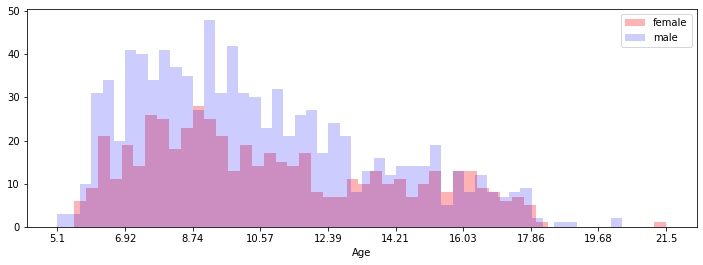

In [8]:
fig, ax = pyplot.subplots(figsize=(12,4))
ax.hist(data['thickness_L']['X'][np.where(data['thickness_L']['X'][:,1]==1)[0],0], bins=50, alpha=0.3, color='r', label='female')
ax.hist(data['thickness_L']['X'][np.where(data['thickness_L']['X'][:,1]==0)[0],0], bins=50, alpha=0.2, color='b', label='male')
ax.set_xticks(np.linspace(0,1,10))
ax.set_xticklabels(np.round(np.linspace(5.1, 21.5,10),2))
ax.legend()
ax.set_xlabel('Age')
pyplot.show()

In [9]:
experiment = 'SpatialReg_20210916'
savepath = os.path.join(  '/mnt_homes/home4T3/lamk5/mlt-external/factor_to_mesh' , 'output/'+experiment )

In [ ]:
# measure_list = ['curv_L', 'sulc_L', 'thickness_L'] + ['curv_R', 'sulc_R', 'thickness_R']

result = dict()
result['curv_L'] = LaplacianModel(data, 'curv_L', savepath,
                                  nrings=3, mu0=1e-12, gamma=1000, niters=300,
                                  plot_interactive=True, plot_png=True)

result['sulc_L'] = LaplacianModel(data, 'sulc_L', savepath,
                                  nrings=3, mu0=1e-12, gamma=1000, niters=300,
                                  plot_interactive=True, plot_png=True)

result['thickness_L'] = LaplacianModel(data, 'thickness_L', savepath,
                                  nrings=2, mu0=1e-11, gamma=1000, niters=300,
                                  plot_interactive=True, plot_png=True)

# with open(os.path.join(savepath, 'results.pickle'), 'wb') as handle:
#             pickle.dump(result, handle, protocol=4)

curv_L L


loss=7.8653e+05, MU=2.0000E-12: 100%|██████████| 300/300 [02:46<00:00,  1.80it/s]
/home/lamk5/miniconda3/envs/tf2-4/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Generating figures for factor 1


/home/lamk5/miniconda3/envs/tf2-4/lib/python3.8/site-packages/nilearn/plotting/js_plotting_utils.py:76: UserWarning: you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True
  warnings.warn('you have specified symmetric_cmap=False '
/home/lamk5/miniconda3/envs/tf2-4/lib/python3.8/site-packages/nilearn/plotting/js_plotting_utils.py:81: UserWarning: vmin cannot be chosen when cmap is symmetric
  warnings.warn('vmin cannot be chosen when cmap is symmetric')


Generating figures for factor 2
Generating figures for factor 3
Generating figures for factor 4
Generating figures for factor 5
Generating figures for factor 6
Generating figures for factor 7
Generating figures for factor 8
Generating figures for factor 9
Generating figures for factor 10


/home/lamk5/miniconda3/envs/tf2-4/lib/python3.8/site-packages/nilearn/plotting/html_document.py:56: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '


Generating figures for factor 11
Generating figures for factor 12
Generating figures for factor 13
Generating figures for factor 14
Generating figures for intercept
/mnt_homes/home4T3/lamk5/mlt-external/factor_to_mesh/output/SpatialReg_20210916/curv_L-correlation L
Generating figures for correlation
sulc_L L


loss=1.1122e+06, MU=2.0000E-12: 100%|██████████| 300/300 [02:56<00:00,  1.70it/s]
/home/lamk5/miniconda3/envs/tf2-4/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Generating figures for factor 1


/home/lamk5/miniconda3/envs/tf2-4/lib/python3.8/site-packages/nilearn/plotting/js_plotting_utils.py:76: UserWarning: you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True
  warnings.warn('you have specified symmetric_cmap=False '
/home/lamk5/miniconda3/envs/tf2-4/lib/python3.8/site-packages/nilearn/plotting/js_plotting_utils.py:81: UserWarning: vmin cannot be chosen when cmap is symmetric
  warnings.warn('vmin cannot be chosen when cmap is symmetric')
/home/lamk5/miniconda3/envs/tf2-4/lib/python3.8/site-packages/nilearn/plotting/html_document.py:56: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '


Generating figures for factor 2
Generating figures for factor 3
Generating figures for factor 4
Generating figures for factor 5
Generating figures for factor 6
Generating figures for factor 7
Generating figures for factor 8
Generating figures for factor 9
Generating figures for factor 10
Generating figures for factor 11
Generating figures for factor 12
Generating figures for factor 13
Generating figures for factor 14
Generating figures for intercept
/mnt_homes/home4T3/lamk5/mlt-external/factor_to_mesh/output/SpatialReg_20210916/sulc_L-correlation L
Generating figures for correlation
thickness_L L


loss=1.7821e+05, MU=4.0000E-11: 100%|██████████| 300/300 [02:13<00:00,  2.25it/s]
/home/lamk5/miniconda3/envs/tf2-4/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Generating figures for factor 1


/home/lamk5/miniconda3/envs/tf2-4/lib/python3.8/site-packages/nilearn/plotting/js_plotting_utils.py:76: UserWarning: you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True
  warnings.warn('you have specified symmetric_cmap=False '
/home/lamk5/miniconda3/envs/tf2-4/lib/python3.8/site-packages/nilearn/plotting/js_plotting_utils.py:81: UserWarning: vmin cannot be chosen when cmap is symmetric
  warnings.warn('vmin cannot be chosen when cmap is symmetric')
/home/lamk5/miniconda3/envs/tf2-4/lib/python3.8/site-packages/nilearn/plotting/html_document.py:56: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '


Generating figures for factor 2
Generating figures for factor 3
Generating figures for factor 4
Generating figures for factor 5
Generating figures for factor 6
Generating figures for factor 7
Generating figures for factor 8
Generating figures for factor 9
Generating figures for factor 10
Generating figures for factor 11
Generating figures for factor 12
Generating figures for factor 13
Generating figures for factor 14
Generating figures for intercept


In [ ]:
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

ncol=3
nrow=1

pyplot.figure(figsize = (ncol*6,nrow*8))
gs = gridspec.GridSpec(nrow, ncol, wspace=0.0, hspace=0.0,
                       top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
                       left=0.5/(ncol+1), right=1-0.5/(ncol+1))
for row in range(nrow):
    
    img = mpimg.imread(os.path.join(savepath, 'curv_L-correlation.png'))
    ax = pyplot.subplot(gs[row,0])
    ax.imshow(img)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_axis_off()
    if row == 0:
        ax.set_title('Curv Left correlation', fontsize=20)
    
    img = mpimg.imread(os.path.join(savepath, 'sulc_L-correlation.png'))
    ax = pyplot.subplot(gs[row,1])
    ax.imshow(img)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_axis_off()
    if row == 0:
        ax.set_title('Sulc Left correlation', fontsize=20)
    
    img = mpimg.imread(os.path.join(savepath, 'thickness_L-correlation.png'))
    ax = pyplot.subplot(gs[row,2])
    ax.imshow(img)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_axis_off()
    if row == 0:
        ax.set_title('Thickness Left correlation', fontsize=20)

pyplot.show()


In [ ]:
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

ncol=4
nrow=14

pyplot.figure(figsize = (ncol*6,nrow*5))
gs = gridspec.GridSpec(nrow, ncol, wspace=0.0, hspace=0.0,
                       top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
                       left=0.5/(ncol+1), right=1-0.5/(ncol+1))


wordcloud_path = os.path.join('/mnt_homes/home4T3/lamk5/mlt-external/factor_to_mesh/output/',
                              'k{}_wordclouds'.format(12) )

for row in range(nrow):
    
    img = mpimg.imread(os.path.join(wordcloud_path, 'group{}.png'.format(row+1)))
    ax = pyplot.subplot(gs[row,0])
    ax.imshow(img)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_axis_off()
    if row == 0:
        ax.set_title('Curv left weight', fontsize=20)
    
    img = mpimg.imread(os.path.join(savepath, 'curv_L-k{}.png'.format(row+1)))
    ax = pyplot.subplot(gs[row,1])
    ax.imshow(img)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_axis_off()
    if row == 0:
        ax.set_title('Curv left weight', fontsize=20)
    
    img = mpimg.imread(os.path.join(savepath, 'sulc_L-k{}.png'.format(row+1)))
    ax = pyplot.subplot(gs[row,2])
    ax.imshow(img)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_axis_off()
    if row == 0:
        ax.set_title('Sulc left weight', fontsize=20)
    
    img = mpimg.imread(os.path.join(savepath, 'thickness_L-k{}.png'.format(row+1)))
    ax = pyplot.subplot(gs[row,3])
    ax.imshow(img)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_axis_off()
    if row == 0:
        ax.set_title('Thickness left weight', fontsize=20)

pyplot.show()
